In [1]:
!pip install xgboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels.api as sm
import xgboost as xgb
import scipy as sp
%reload_ext autoreload
%autoreload 2
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [5]:
#순간: 레코드 인덱스
#dteday : 날짜
#계절: 계절 (1:겨울, 2:봄, 3:여름, 4:가을)
#연도: (0: 2011, 1:2012)
#월: 월( 1 ~ 12)
#공휴일 : 날씨의 날이 공휴일인지 아닌지 ([Web Link]에서 발췌)
#weekdaynum: 요일
#is_workingday: 요일이 주말도 휴일도 아닌 경우 1, 그렇지 않으면 0입니다.
#*weathersituation:
#-1: 맑음, 약간 흐림, 약간 흐림
#-2: 안개 + 흐림, 안개 + 부서진 구름, 안개 + 약간의 구름, 안개
#-3: 가벼운 눈, 가벼운 비 + 뇌우 + 흩어진 구름, 가벼운 비 + 흩어진 구름
#-4: 폭우 + 얼음 팔레트 + 뇌우 + 안개, 눈 + 안개
#atemp_normalized: 섭씨로 표준화된 느낌 온도입니다.
#-값은 (t-tmin)/(tmax-tmin), tmin=-16, t_max=+50(시간 단위로만)을 통해 파생됩니다.
#-습도_정규화: 정규화된 습도. 값은 100(최대)으로 나뉩니다.
#windspeed_normalized: 정규화된 풍속. 값은 67(최대)로 나뉩니다.
#total_rental: 일반 및 등록 자전거를 포함한 총 대여 자전거 수

In [357]:
bike = pd.read_csv('train.csv', encoding='cp949')
bike

,ID,dteday,season,year,Month,is_holiday,weekdaynum,is_workingday,weathersituation,atemp_normalized,humidity_normalized,windspeed_normalized,total_rental
0,A1,01-01-2011,1,0,1,0,6,0,2,0.363625,0.805833,0.160446,985
1,A2,02-01-2011,1,0,1,0,0,0,2,0.353739,0.696087,0.248539,801
2,A3,03-01-2011,1,0,1,0,1,1,1,0.189405,0.437273,0.248309,1349
3,A4,04-01-2011,1,0,1,0,2,1,1,0.212122,0.590435,0.160296,1562
4,A5,05-01-2011,1,0,1,0,3,1,1,0.229270,0.436957,0.186900,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...
594,A595,17-08-2012,3,1,8,0,5,1,1,0.242400,0.570833,0.231354,7148
595,A596,18-08-2012,3,1,8,0,6,0,1,0.618071,0.603333,0.177867,7865
596,A597,19-08-2012,3,1,8,0,0,0,2,0.603554,0.711667,0.086450,4549
597,A598,20-08-2012,3,1,8,0,1,1,2,0.595967,0.734167,0.129979,6530


In [175]:
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    599 non-null    object 
 1   dteday                599 non-null    object 
 2   season                599 non-null    int64  
 3   year                  599 non-null    int64  
 4   Month                 599 non-null    int64  
 5   is_holiday            599 non-null    int64  
 6   weekdaynum            599 non-null    int64  
 7   is_workingday         599 non-null    int64  
 8   weathersituation      599 non-null    int64  
 9   atemp_normalized      599 non-null    float64
 10  humidity_normalized   599 non-null    float64
 11  windspeed_normalized  599 non-null    float64
 12  total_rental          599 non-null    int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 61.0+ KB


<AxesSubplot:>

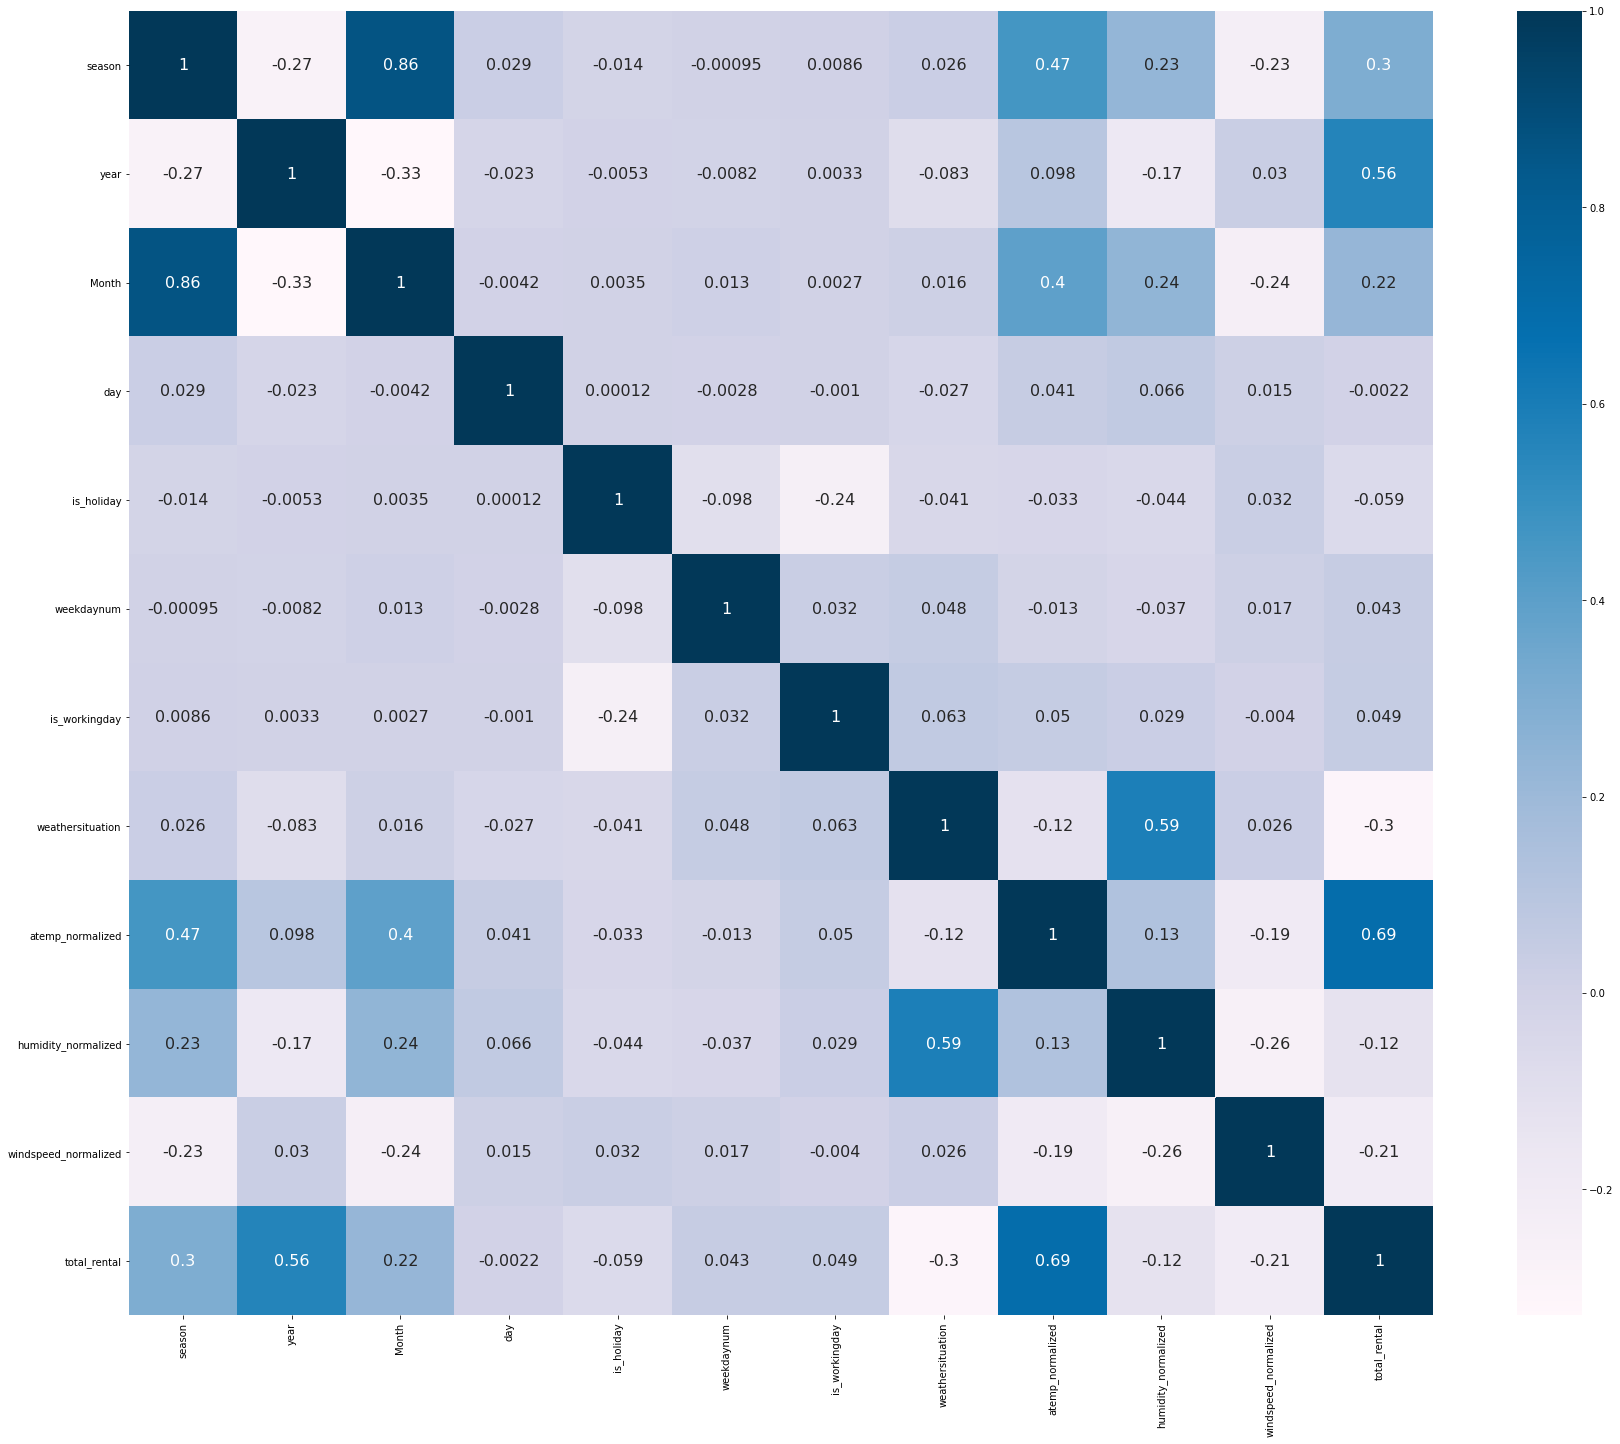

In [197]:
heatmap_data = bike[['season', 'year', 'Month','day','is_holiday', 'weekdaynum', 'is_workingday',
       'weathersituation', 'atemp_normalized', 'humidity_normalized',
       'windspeed_normalized','total_rental']]

colormap = plt.cm.PuBu
plt.figure(figsize=(30, 24))
sns.heatmap(heatmap_data.astype(float).corr(),square = True, cmap = colormap, linecolor = "white",
            annot = True, annot_kws = {"size" : 16})

In [359]:
del bike['ID']
del bike['dteday']

In [360]:
date = pd.date_range('2011-01-01','2012-08-21',freq='D')
date

DatetimeIndex(['2011-01-01', '2011-01-02', '2011-01-03', '2011-01-04',
               '2011-01-05', '2011-01-06', '2011-01-07', '2011-01-08',
               '2011-01-09', '2011-01-10',
               ...
               '2012-08-12', '2012-08-13', '2012-08-14', '2012-08-15',
               '2012-08-16', '2012-08-17', '2012-08-18', '2012-08-19',
               '2012-08-20', '2012-08-21'],
              dtype='datetime64[ns]', length=599, freq='D')

In [361]:
bike['datetime']=date
bike['day']=bike['datetime'].dt.day 

In [362]:
bike['datetime'] = pd.to_datetime(bike['datetime'])
bike.asfreq('D').index
bike.set_index('datetime', inplace = True)

In [334]:
bike

,season,year,Month,is_holiday,weekdaynum,is_workingday,weathersituation,atemp_normalized,humidity_normalized,windspeed_normalized,total_rental,day
datetime,,,,,,,,,,,,
2011-01-01,1,0,1,0,6,0,2,0.363625,0.805833,0.160446,985,1
2011-01-02,1,0,1,0,0,0,2,0.353739,0.696087,0.248539,801,2
2011-01-03,1,0,1,0,1,1,1,0.189405,0.437273,0.248309,1349,3
2011-01-04,1,0,1,0,2,1,1,0.212122,0.590435,0.160296,1562,4
2011-01-05,1,0,1,0,3,1,1,0.229270,0.436957,0.186900,1600,5
...,...,...,...,...,...,...,...,...,...,...,...,...
2012-08-17,3,1,8,0,5,1,1,0.242400,0.570833,0.231354,7148,17
2012-08-18,3,1,8,0,6,0,1,0.618071,0.603333,0.177867,7865,18
2012-08-19,3,1,8,0,0,0,2,0.603554,0.711667,0.086450,4549,19


<AxesSubplot:xlabel='datetime'>

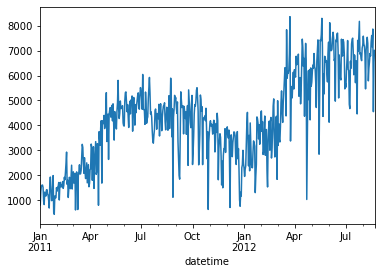

In [11]:
bike['total_rental'].plot()

In [335]:
a=bike[bike['year']==0]
bike['total_rental'][0:365]=a['total_rental']+2000

<ipython-input-335-a92d370780d7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bike['total_rental'][0:365]=a['total_rental']+2000
C:\Users\ie\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [336]:
bike

,season,year,Month,is_holiday,weekdaynum,is_workingday,weathersituation,atemp_normalized,humidity_normalized,windspeed_normalized,total_rental,day
datetime,,,,,,,,,,,,
2011-01-01,1,0,1,0,6,0,2,0.363625,0.805833,0.160446,2985,1
2011-01-02,1,0,1,0,0,0,2,0.353739,0.696087,0.248539,2801,2
2011-01-03,1,0,1,0,1,1,1,0.189405,0.437273,0.248309,3349,3
2011-01-04,1,0,1,0,2,1,1,0.212122,0.590435,0.160296,3562,4
2011-01-05,1,0,1,0,3,1,1,0.229270,0.436957,0.186900,3600,5
...,...,...,...,...,...,...,...,...,...,...,...,...
2012-08-17,3,1,8,0,5,1,1,0.242400,0.570833,0.231354,7148,17
2012-08-18,3,1,8,0,6,0,1,0.618071,0.603333,0.177867,7865,18
2012-08-19,3,1,8,0,0,0,2,0.603554,0.711667,0.086450,4549,19


<AxesSubplot:xlabel='datetime'>

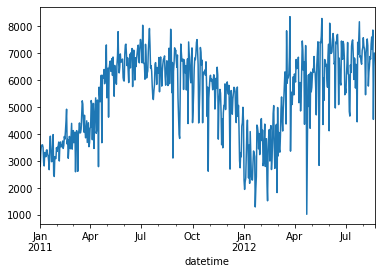

In [16]:
bike['total_rental'].plot()

In [343]:
for j in range(0,2):
    for i in range(1,13):
        globals()['y{}m{}'.format(j,i)]=bike[(bike['year']==j)&(bike['Month']==i)].describe()['total_rental'][1]

In [344]:
diff1=y1m1-y0m1
diff2=y1m2-y0m2
diff3=y1m3-y0m3
diff4=y1m4-y0m4
diff5=y1m5-y0m5
diff6=y1m6-y0m6
diff7=y1m7-y0m7
diff8=y1m8-y0m8

In [345]:
diff5

1936.9032258064517

In [346]:
a=[diff1,diff2,diff3,diff4,diff5,diff6,diff7,diff8]
diff9=np.percentile(a,50)

In [347]:
for i in range(365):
    if bike['Month'][i]==1 and bike['year'][i]==0:
        bike.total_rental[i] += diff1
    elif bike['Month'][i]==2 and bike['year'][i]==0:
        bike.total_rental[i] += diff2
    elif bike['Month'][i]==3 and bike['year'][i]==0:
        bike.total_rental[i] += diff3
    elif bike['Month'][i]==4 and bike['year'][i]==0:
        bike.total_rental[i] += diff4
    elif bike['Month'][i]==5 and bike['year'][i]==0:
        bike.total_rental[i] += diff5
    elif bike['Month'][i]==6 and bike['year'][i]==0:
        bike.total_rental[i] += diff6
    elif bike['Month'][i]==7 and bike['year'][i]==0:
        bike.total_rental[i] += diff7
    elif bike['Month'][i]==8 and bike['year'][i]==0:
        bike.total_rental[i] += diff8
    else:
        bike.total_rental[i] += diff9

<ipython-input-347-001937d0576a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bike.total_rental[i] += diff1
<ipython-input-347-001937d0576a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bike.total_rental[i] += diff2
<ipython-input-347-001937d0576a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bike.total_rental[i] += diff3
<ipython-input-347-001937d0576a>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

In [348]:
bike

,season,year,Month,is_holiday,weekdaynum,is_workingday,weathersituation,atemp_normalized,humidity_normalized,windspeed_normalized,total_rental,day
datetime,,,,,,,,,,,,
2011-01-01,1,0,1,0,6,0,2,0.363625,0.805833,0.160446,2873,1
2011-01-02,1,0,1,0,0,0,2,0.353739,0.696087,0.248539,2689,2
2011-01-03,1,0,1,0,1,1,1,0.189405,0.437273,0.248309,3237,3
2011-01-04,1,0,1,0,2,1,1,0.212122,0.590435,0.160296,3450,4
2011-01-05,1,0,1,0,3,1,1,0.229270,0.436957,0.186900,3488,5
...,...,...,...,...,...,...,...,...,...,...,...,...
2012-08-17,3,1,8,0,5,1,1,0.242400,0.570833,0.231354,7148,17
2012-08-18,3,1,8,0,6,0,1,0.618071,0.603333,0.177867,7865,18
2012-08-19,3,1,8,0,0,0,2,0.603554,0.711667,0.086450,4549,19


In [251]:
bike

,season,year,Month,is_holiday,weekdaynum,is_workingday,weathersituation,atemp_normalized,humidity_normalized,windspeed_normalized,total_rental,day
datetime,,,,,,,,,,,,
2011-01-01,1,0,1,0,6,0,2,0.363625,0.805833,0.160446,985,1
2011-01-02,1,0,1,0,0,0,2,0.353739,0.696087,0.248539,801,2
2011-01-03,1,0,1,0,1,1,1,0.189405,0.437273,0.248309,1349,3
2011-01-04,1,0,1,0,2,1,1,0.212122,0.590435,0.160296,1562,4
2011-01-05,1,0,1,0,3,1,1,0.229270,0.436957,0.186900,1600,5
...,...,...,...,...,...,...,...,...,...,...,...,...
2012-08-17,3,1,8,0,5,1,1,0.242400,0.570833,0.231354,7148,17
2012-08-18,3,1,8,0,6,0,1,0.618071,0.603333,0.177867,7865,18
2012-08-19,3,1,8,0,0,0,2,0.603554,0.711667,0.086450,4549,19


In [48]:
adf_test(bike['total_rental'])

Results of Dickey-Fuller Test:
Test Statistic                  -2.438016
p-value                          0.359612
Lags Used                        9.000000
Number of Observations Used    589.000000
Critical Value (1%)             -3.974223
Critical Value (5%)             -3.417970
Critical Value (10%)            -3.131451
dtype: float64
정상시계열이 아니라는 귀무가설을 5.0%의 유의수준으로 기각할 수 없으므로 해당 데이터는 정상성을 보장하지 못합니다.


In [49]:
def kpss_test(timeseries, pvalue = .05, regression_option = 'ct'):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression= regression_option)
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
    if kpss_output[1] < pvalue:
        print(f"정상시계열이 맞다는 귀무가설을 {pvalue*100}%의 유의수준으로 기각할 수 있으므로 해당 데이터는 정상성을 보장하지 못합니다.")
    else:
        print(f"정상시계열이 맞다는 귀무가설을 {pvalue*100}%의 유의수준으로 기각할 수 없으므로 해당 데이터는 정상성이 보장됩니다.")
        

kpss_test(bike['total_rental'])

Results of KPSS Test:
Test Statistic            0.312401
p-value                   0.010000
Lags Used                19.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64
정상시계열이 맞다는 귀무가설을 5.0%의 유의수준으로 기각할 수 있으므로 해당 데이터는 정상성을 보장하지 못합니다.


C:\Users\ie\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1843: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\ie\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1874: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(warn_msg.format(direction="smaller"), InterpolationWarning)


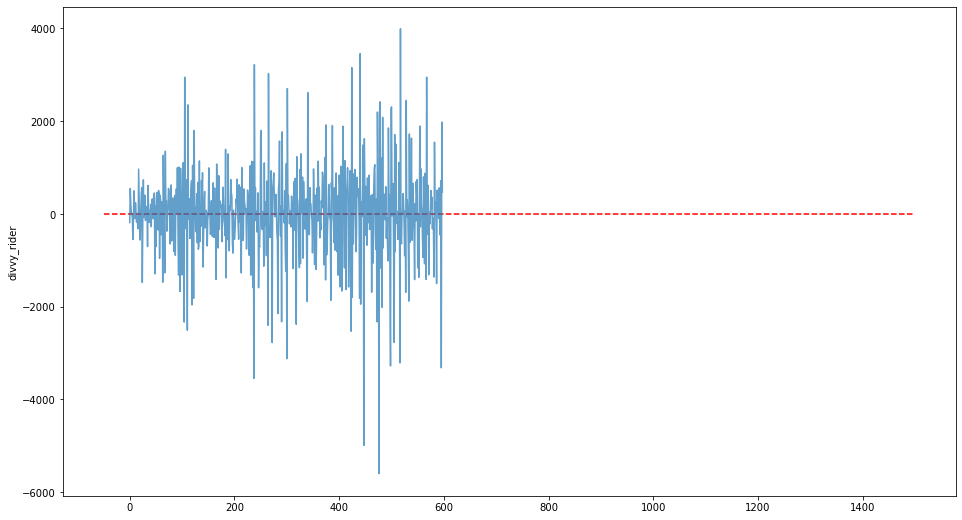

In [12]:
diff_data = bike['total_rental'].diff(1).dropna()

# 표 그리기
plt.figure(figsize=(16,9))
plt.plot(diff_data.values, alpha=.7)
plt.hlines(y=diff_data.mean(), xmin=-50, xmax=1500, colors='red', linestyles='dashed')
plt.ylabel('divvy_rider')
plt.show()

In [13]:
diff_data

datetime
2011-01-02    -184.0
2011-01-03     548.0
2011-01-04     213.0
2011-01-05      38.0
2011-01-06       6.0
               ...  
2012-08-17    -457.0
2012-08-18     717.0
2012-08-19   -3316.0
2012-08-20    1981.0
2012-08-21     476.0
Name: total_rental, Length: 598, dtype: float64

In [27]:
bike['diff_data']=diff_data

In [37]:
bike['diff_data'][0]=0

<ipython-input-37-edff7228a644>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bike['diff_data'][0]=0


In [38]:
bike

,season,year,Month,is_holiday,weekdaynum,is_workingday,weathersituation,atemp_normalized,humidity_normalized,windspeed_normalized,total_rental,diff_data
datetime,,,,,,,,,,,,
2011-01-01,1,0,1,0,6,0,2,0.363625,0.805833,0.160446,985,0.0
2011-01-02,1,0,1,0,0,0,2,0.353739,0.696087,0.248539,801,-184.0
2011-01-03,1,0,1,0,1,1,1,0.189405,0.437273,0.248309,1349,548.0
2011-01-04,1,0,1,0,2,1,1,0.212122,0.590435,0.160296,1562,213.0
2011-01-05,1,0,1,0,3,1,1,0.229270,0.436957,0.186900,1600,38.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2012-08-17,3,1,8,0,5,1,1,0.242400,0.570833,0.231354,7148,-457.0
2012-08-18,3,1,8,0,6,0,1,0.618071,0.603333,0.177867,7865,717.0
2012-08-19,3,1,8,0,0,0,2,0.603554,0.711667,0.086450,4549,-3316.0


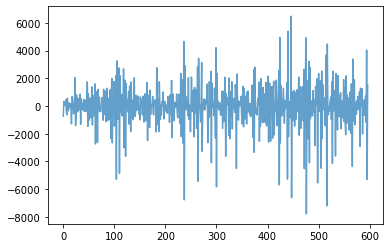

In [25]:
plt.plot(diff_data1.values, alpha=.7)

In [51]:
adf_test(diff_data)

Results of Dickey-Fuller Test:
Test Statistic                -1.080074e+01
p-value                        5.383284e-17
Lags Used                      1.200000e+01
Number of Observations Used    5.850000e+02
Critical Value (1%)           -3.974329e+00
Critical Value (5%)           -3.418022e+00
Critical Value (10%)          -3.131481e+00
dtype: float64
정상시계열이 아니라는 귀무가설을 5.0%의 유의수준으로 기각할 수 있으므로 해당 데이터는 정상성이 보장됩니다.


In [52]:
kpss_test(diff_data)

Results of KPSS Test:
Test Statistic            0.04052
p-value                   0.10000
Lags Used                19.00000
Critical Value (10%)      0.11900
Critical Value (5%)       0.14600
Critical Value (2.5%)     0.17600
Critical Value (1%)       0.21600
dtype: float64
정상시계열이 맞다는 귀무가설을 5.0%의 유의수준으로 기각할 수 없으므로 해당 데이터는 정상성이 보장됩니다.


C:\Users\ie\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1843: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\ie\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1876: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(warn_msg.format(direction="greater"), InterpolationWarning)


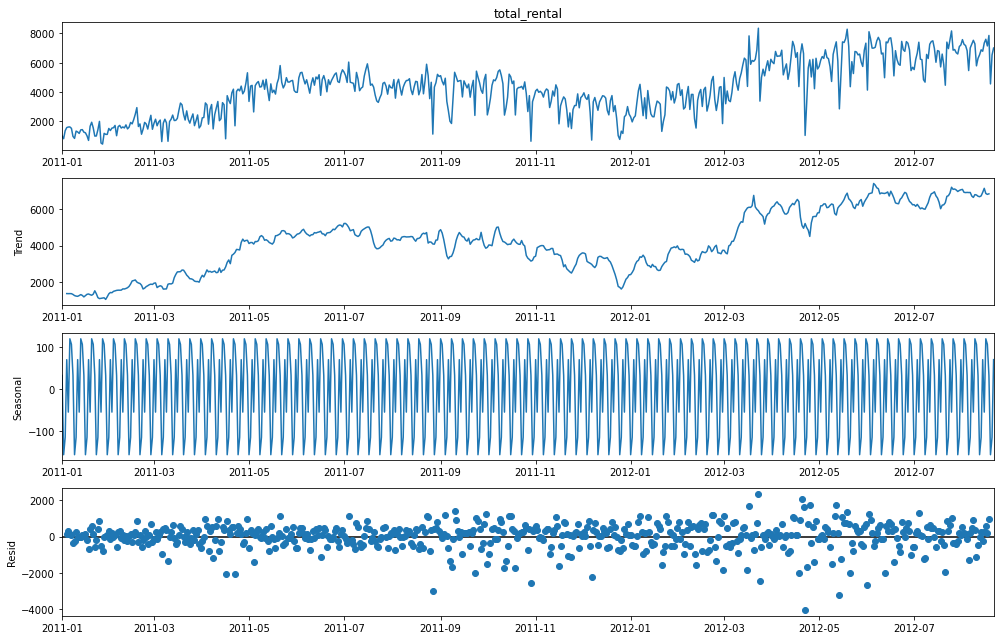

In [363]:
#split data as trend + seasonal + residual
plt.rcParams['figure.figsize'] = (14,9)
sm.tsa.seasonal_decompose(bike['total_rental'], model='additive').plot()
plt.show()

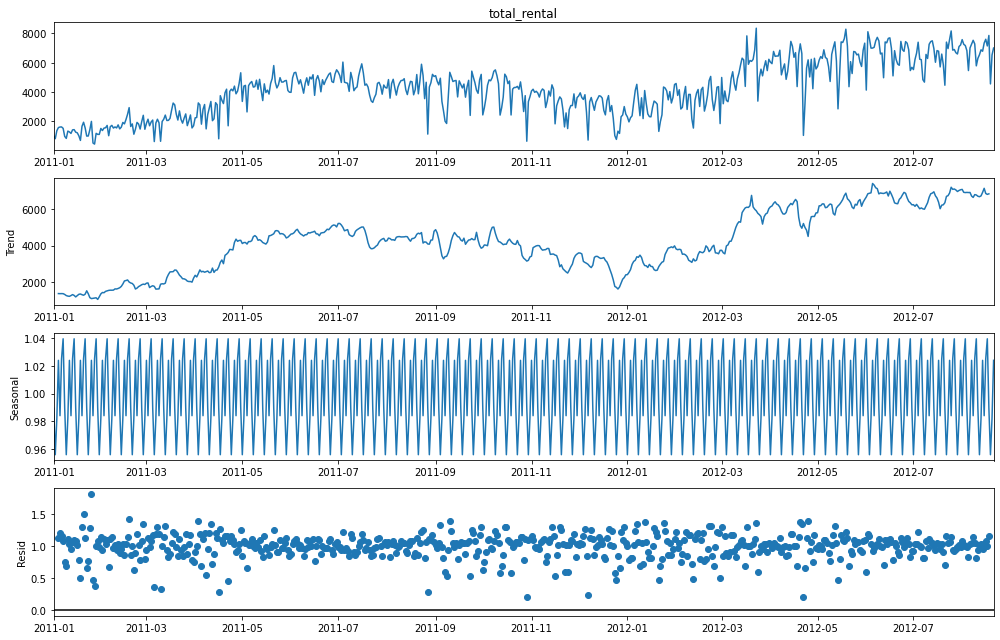

In [53]:
sm.tsa.seasonal_decompose(bike['total_rental'], model='multiplicative').plot()
plt.show()

# 여기

In [350]:
decompose = sm.tsa.seasonal_decompose(bike['total_rental'], model='additive')
trend = pd.DataFrame(decompose.trend)
trend.fillna(method='ffill', inplace=True)
trend.fillna(method='bfill', inplace=True)
trend.columns = ['trend_total']

seasonal = pd.DataFrame(decompose.seasonal)
seasonal.columns = ['seasonal_total']

resid = pd.DataFrame(decompose.resid)
resid.columns = ['resid_total']
resid.fillna(method='ffill', inplace=True)
resid.fillna(method='bfill', inplace=True)

bike = pd.concat([bike, trend, seasonal, resid],axis=1)
bike

,season,year,Month,is_holiday,weekdaynum,is_workingday,weathersituation,atemp_normalized,humidity_normalized,windspeed_normalized,total_rental,day,trend_total,seasonal_total,resid_total
datetime,,,,,,,,,,,,,,,
2011-01-01,1,0,1,0,6,0,2,0.363625,0.805833,0.160446,2873,1,3232.714286,39.384002,141.463057
2011-01-02,1,0,1,0,0,0,2,0.353739,0.696087,0.248539,2689,2,3232.714286,-178.504173,141.463057
2011-01-03,1,0,1,0,1,1,1,0.189405,0.437273,0.248309,3237,3,3232.714286,-128.567098,141.463057
2011-01-04,1,0,1,0,2,1,1,0.212122,0.590435,0.160296,3450,4,3232.714286,75.822658,141.463057
2011-01-05,1,0,1,0,3,1,1,0.229270,0.436957,0.186900,3488,5,3229.000000,-45.602552,304.602552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-08-17,3,1,8,0,5,1,1,0.242400,0.570833,0.231354,7148,17,6832.571429,110.325179,205.103393
2012-08-18,3,1,8,0,6,0,1,0.618071,0.603333,0.177867,7865,18,6864.285714,39.384002,961.330284
2012-08-19,3,1,8,0,0,0,2,0.603554,0.711667,0.086450,4549,19,6864.285714,-178.504173,961.330284


In [92]:
bike['seasonal_total'].unique()

array([  42.2327531 , -167.08543417, -122.05312125,   66.40082033,
        -55.3185074 ,  122.83779512,  112.98569428])

In [ ]:
-55.3185074 ,  122.83779512,  112.98569428, 42.2327531 , -167.08543417, -122.05312125,   66.40082033

In [93]:
bike.columns

Index(['season', 'year', 'Month', 'is_holiday', 'weekdaynum', 'is_workingday',
       'weathersituation', 'atemp_normalized', 'humidity_normalized',
       'windspeed_normalized', 'total_rental', 'trend_total',
       'seasonal_total'],
      dtype='object')

In [351]:
features = ['season', 'year', 'Month', 'is_holiday', 'weekdaynum', 'is_workingday',
       'weathersituation', 'atemp_normalized', 'humidity_normalized',
       'windspeed_normalized']

In [352]:
train_x = bike[features]

In [353]:
train_y = bike['resid_total']

In [148]:
train_bike, val_bike = train_test_split(bike, test_size= 0.2 , shuffle = True)

In [151]:
train_x = train_bike[features]
train_y = train_bike['total_rental']

val_x = val_bike[features]
val_y = val_bike['total_rental']

In [154]:
from xgboost import XGBRegressor

train = xgb.DMatrix(data=train_x, label = train_y)
val = xgb.DMatrix(data=val_x, label = val_y)
wlist = [(train, 'train'), (val,'eval')]

params = {
    'learning_rate': 0.05,
    'objective': 'reg:squarederror',
    'metric':'mae', 
    'seed':42
}

model = xgb.train(params, train, 500, evals=wlist, verbose_eval=20, early_stopping_rounds=300)

[16:43:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "metric" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:5346.67041	eval-rmse:5455.52832
[20]	train-rmse:2019.38025	eval-rmse:2040.28894
[40]	train-rmse:825.81909	eval-rmse:899.26819
[60]	train-rmse:400.03253	eval-rmse:605.18298
[80]	train-rmse:249.22064	eval-rmse:549.56049
[100]	train-rmse:191.77701	eval-rmse:541.57037
[120]	train-rmse:164.79837	eval-rmse:539.21472
[140]	train-rmse:147.80112	eval-rmse:541.16003
[160]	train-rmse:135.80710	eval-rmse:543.63922
[180]	train-rmse:120.38618	eval-rmse:545.13477
[200]	train-rmse:110.19102	eval-rmse:545.30029
[220]	train-rmse:101.81361	eval-rmse:544.54047
[240]	train-rmse:94.57143	eval-rmse:545.47022
[260]	

In [354]:
RF = RandomForestRegressor(random_state=0, n_jobs=-1)

In [355]:
RF_model = RF.fit(train_x,train_y)

In [356]:
test = pd.read_csv('test.csv',encoding = 'cp949')
test

,ID,dteday,season,year,Month,is_holiday,weekdaynum,is_workingday,weathersituation,atemp_normalized,humidity_normalized,windspeed_normalized
0,A600,22-08-2012,3,1,8,0,3,1,1,0.621854,0.677083,0.070283
1,A601,23-08-2012,3,1,8,0,4,1,1,0.637008,0.635833,0.084596
2,A602,24-08-2012,3,1,8,0,5,1,2,0.647100,0.615000,0.072146
3,A603,25-08-2012,3,1,8,0,6,0,2,0.618696,0.712917,0.244408
4,A604,26-08-2012,3,1,8,0,0,0,2,0.595996,0.845833,0.228858
...,...,...,...,...,...,...,...,...,...,...,...,...
126,A726,26-12-2012,1,1,12,0,3,1,3,0.220333,0.823333,0.316546
127,A727,27-12-2012,1,1,12,0,4,1,2,0.226642,0.652917,0.350133
128,A728,28-12-2012,1,1,12,0,5,1,2,0.255046,0.590000,0.155471
129,A729,29-12-2012,1,1,12,0,6,0,2,0.242400,0.752917,0.124383


In [114]:
data = {'seasonal_total': [-55.3185074 ,  122.83779512,  112.98569428, 42.2327531 , -167.08543417, -122.05312125,   66.40082033]*19}

In [115]:
a= pd.DataFrame(data=data)
b=a[0:131]

In [116]:
test = pd.concat([test, b], axis=1)
test

,ID,dteday,season,year,Month,is_holiday,weekdaynum,is_workingday,weathersituation,atemp_normalized,humidity_normalized,windspeed_normalized,seasonal_total
0,A600,22-08-2012,3,1,8,0,3,1,1,0.621854,0.677083,0.070283,-55.318507
1,A601,23-08-2012,3,1,8,0,4,1,1,0.637008,0.635833,0.084596,122.837795
2,A602,24-08-2012,3,1,8,0,5,1,2,0.647100,0.615000,0.072146,112.985694
3,A603,25-08-2012,3,1,8,0,6,0,2,0.618696,0.712917,0.244408,42.232753
4,A604,26-08-2012,3,1,8,0,0,0,2,0.595996,0.845833,0.228858,-167.085434
...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,A726,26-12-2012,1,1,12,0,3,1,3,0.220333,0.823333,0.316546,-55.318507
127,A727,27-12-2012,1,1,12,0,4,1,2,0.226642,0.652917,0.350133,122.837795
128,A728,28-12-2012,1,1,12,0,5,1,2,0.255046,0.590000,0.155471,112.985694
129,A729,29-12-2012,1,1,12,0,6,0,2,0.242400,0.752917,0.124383,42.232753


In [322]:
test_x = test[features]

In [323]:
a=RF_model.predict(test_x)

In [158]:
test_xD = xgb.DMatrix(test_x)
b=model.predict(test_xD)

In [324]:
test['total_rental']=a

In [325]:
test

,ID,dteday,season,year,Month,is_holiday,weekdaynum,is_workingday,weathersituation,atemp_normalized,humidity_normalized,windspeed_normalized,resid_total,total_rental
0,A600,22-08-2012,3,1,8,0,3,1,1,0.621854,0.677083,0.070283,620.102580,7317.03
1,A601,23-08-2012,3,1,8,0,4,1,1,0.637008,0.635833,0.084596,430.508714,7304.17
2,A602,24-08-2012,3,1,8,0,5,1,2,0.647100,0.615000,0.072146,790.699609,7462.69
3,A603,25-08-2012,3,1,8,0,6,0,2,0.618696,0.712917,0.244408,-614.488401,5905.41
4,A604,26-08-2012,3,1,8,0,0,0,2,0.595996,0.845833,0.228858,-1238.986187,5104.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,A726,26-12-2012,1,1,12,0,3,1,3,0.220333,0.823333,0.316546,-1447.693662,3546.93
127,A727,27-12-2012,1,1,12,0,4,1,2,0.226642,0.652917,0.350133,-393.656118,3823.89
128,A728,28-12-2012,1,1,12,0,5,1,2,0.255046,0.590000,0.155471,-3.159625,4455.03
129,A729,29-12-2012,1,1,12,0,6,0,2,0.242400,0.752917,0.124383,-159.259788,4212.66


In [317]:
features = ['season', 'year', 'Month', 'is_holiday', 'weekdaynum', 'is_workingday',
       'weathersituation', 'atemp_normalized', 'humidity_normalized',
       'windspeed_normalized','resid_total']

In [326]:
sample=test.drop(['dteday','season', 'year','Month', 'is_holiday', 'weekdaynum', 'is_workingday',
       'weathersituation', 'atemp_normalized', 'humidity_normalized',
       'windspeed_normalized','resid_total'],axis=1)

In [327]:
sample

,ID,total_rental
0,A600,7317.03
1,A601,7304.17
2,A602,7462.69
3,A603,5905.41
4,A604,5104.52
...,...,...
126,A726,3546.93
127,A727,3823.89
128,A728,4455.03
129,A729,4212.66


In [328]:
sample.to_csv('result_RF11.csv', index = False)